In [1]:
import torch
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import transformers
import numpy as np
from os import path
import pandas as pd
from constants import *
import dataset_utils as du
from new_model import create_model, create_model_no_stackx, create_model_only_stackx
from training_metrics import TrainMetrics
from evaluation_metrics import EvalMetrics

ModuleNotFoundError: No module named 'torch'

In [2]:
# Uncomment the following line to rerun pre-processing and tokenization
# prepare_and_save(RAW_DATASET_PATH, path.join(PROCESSED_DIR, PROCESSED_DATASET))

data = pd.read_pickle(path.join(PROCESSED_DIR, PROCESSED_DATASET))
interest = du.get_interest_dataset(data) 
interest = du.get_balanced_dataset(interest, 'interest_binary', random_state=1)
interest = interest.sample(frac=1, random_state=1)


/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [4]:
# K-fold split
features = du.get_features(interest)
labels = du.get_labels(interest, 'interest_binary')
folds = du.kfold_split(features, labels, num_folds=8)


# We validated our results on multiple folds, but are using a single fold for demonstration purposes
train_features = folds[0]['train_features']
train_labels = folds[0]['train_labels']
dev_features = folds[0]['test_features']
dev_labels = folds[0]['test_labels']

# Optimal fit

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
348/348 [==============================] - 197s 532ms/step - loss: 0.7060 - accuracy: 0.4759
Epoch 2/10
348/348 [==============================] - 185s 533ms/step - loss: 0.6905 - accuracy: 0.5314
Epoch 3/10
348/348 [==============================

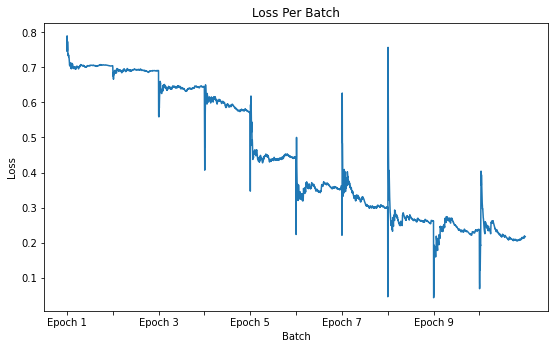

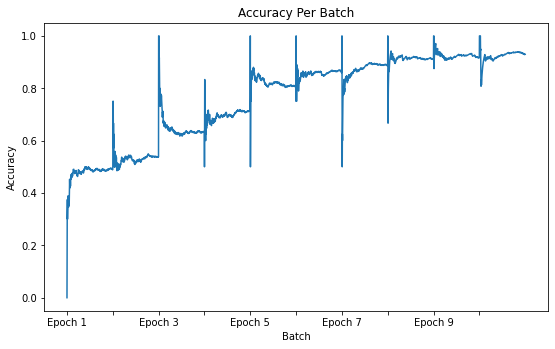

Saved training metrics to metrics/overfit_demo-train.json


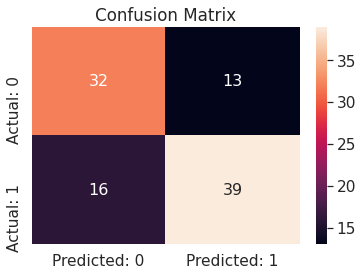

F1 score 0.7106119987940912
Accuracy 0.71


In [5]:
# Hyperparameters
INITIAL_ALPHA = 1e-5
LEARNING_RATE = tf.keras.optimizers.schedules.ExponentialDecay(INITIAL_ALPHA, decay_steps=100, decay_rate=0.9, staircase=True)
BATCH_SIZE = 2
EPOCHS = 10


training_metrics = TrainMetrics('optimal_fit', epochs=EPOCHS)

model = create_model_no_stackx(MAX_LEN, NUM_SX_FEATURES)

model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


hist = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True, callbacks=[training_metrics])

training_metrics.plot_loss()
training_metrics.plot_accuracy()






In [ ]:
dev_preds = model.predict(dev_features, batch_size=BATCH_SIZE)
dev_preds = np.rint(dev_preds).astype(int)
eval_dataset = {'feats': dev_features, 'labels': dev_labels, 'preds': dev_preds}

eval_metrics = EvalMetrics('optimal_fit', dataset=eval_dataset)
eval_metrics.plot_confusion_matrix()
print(f'F1 score {eval_metrics.get_f1score()}')
print(f'Accuracy {eval_metrics.get_accuracy()}')